In [1]:
import pandas as pd
import networkx as nx
import json
import numpy as np
from scipy.sparse import lil_matrix, csr_matrix
from scipy.stats import spearmanr

# Graph Algorithms
import community as community_louvain  # This is the python-louvain library
from networkx.algorithms.cuts import conductance
# Vector Algorithms
from sklearn.decomposition import TruncatedSVD # Better for sparse data than PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, silhouette_score

print("All libraries imported successfully.")

All libraries imported successfully.


In [2]:
# ---
# ## Define File Paths
# ---
# Assuming the script is run from the `work_project1` directory
edges_path = 'Data/musae_facebook_edges.csv'
target_path = 'Data/musae_facebook_target.csv'
features_path = 'Data/musae_facebook_features.json'

In [3]:
# ---
# ## 1. Load All Data
# ---
print(f"\n--- Loading Data ---")

# Load Edges
print(f"Loading edges from {edges_path}...")
edges_df = pd.read_csv(edges_path)
G = nx.from_pandas_edgelist(edges_df, 'id_1', 'id_2')
print(f"Graph loaded: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges.")

# Load Target Labels
print(f"Loading targets from {target_path}...")
target_df = pd.read_csv(target_path)
# Sort by ID to ensure alignment later
target_df = target_df.sort_values(by='id').reset_index(drop=True)

# Convert string labels to integers
label_encoder = LabelEncoder()
target_df['page_type_encoded'] = label_encoder.fit_transform(target_df['page_type'])
# Create a dictionary for easy lookup
true_labels_dict = dict(zip(target_df['id'], target_df['page_type_encoded']))
true_labels_sorted = target_df['page_type_encoded'].values
print(f"Loaded {len(true_labels_sorted)} labels for {len(label_encoder.classes_)} classes.")
print(f"Classes: {list(label_encoder.classes_)}")

# Load Features (JSON)
print(f"Loading features from {features_path}...")
with open(features_path, 'r') as f:
    features_json = json.load(f)


--- Loading Data ---
Loading edges from Data/musae_facebook_edges.csv...
Graph loaded: 22470 nodes, 171002 edges.
Loading targets from Data/musae_facebook_target.csv...
Loaded 22470 labels for 4 classes.
Classes: ['company', 'government', 'politician', 'tvshow']
Loading features from Data/musae_facebook_features.json...


In [4]:
# ---
# ## 2. Prepare Vector Data (Features)
# ---
# We need to convert the JSON features into a sparse matrix (CSR format)
# We must ensure the rows of the matrix align with the sorted target_df
print("\n--- Preparing Vector Data ---")

# Find the maximum feature index to determine the matrix width
max_feature_id = 0
for node_id, features in features_json.items():
    if features:
        max_feature_id = max(max_feature_id, max(features))
num_features = max_feature_id + 1
num_nodes = len(target_df)

print(f"Creating sparse matrix with {num_nodes} nodes and {num_features} features.")

# Use LIL format for efficient row-by-row construction
X_sparse_lil = lil_matrix((num_nodes, num_features), dtype=np.float32)
node_ids_in_order = target_df['id'].values

for i, node_id in enumerate(node_ids_in_order):
    # Get features for this node_id, default to empty list if not in JSON
    features = features_json.get(str(node_id), []) 
    if features:
        # Set the corresponding columns to 1
        X_sparse_lil[i, features] = 1

# Convert to CSR matrix for efficient calculations
X_sparse = X_sparse_lil.tocsr()
print(f"Sparse feature matrix 'X' created. Shape: {X_sparse.shape}")


--- Preparing Vector Data ---
Creating sparse matrix with 22470 nodes and 4714 features.
Sparse feature matrix 'X' created. Shape: (22470, 4714)


In [5]:
# ---
# ---
# # Part 1: Graph Dataset Analysis
# ---
# ---
print(f"\n{'='*20}\n PART 1: GRAPH ALGORITHMS\n{'='*20}")

# ---
# ## A. PageRank and Degree Correlation
# ---
print("\n--- A. PageRank & Degree Correlation ---")

# 1. Calculate PageRank
# alpha=0.85 is the standard damping factor
pagerank = nx.pagerank(G, alpha=0.85)
print("PageRank calculated.")

# 2. Get Node Degrees
degrees = dict(G.degree())
print("Node degrees calculated.")

# 3. Align data for correlation
# We use the sorted node list from the target file to be consistent
# We'll get the PR/degree for each node in that order.
pr_list = []
deg_list = []

for node_id in node_ids_in_order:
    pr_list.append(pagerank.get(node_id, 0)) # Use 0 if node has no edges
    deg_list.append(degrees.get(node_id, 0)) # Use 0 if node has no edges

# 4. Calculate Spearman Correlation
# Spearman is often better as it doesn't assume a linear relationship
corr, p_value = spearmanr(pr_list, deg_list)
print(f"\nSpearman's Correlation (PageRank vs. Degree): {corr:.4f}")
print(f"p-value: {p_value:.4g}")
if p_value < 0.05:
    print("Result: A statistically significant, strong positive correlation.")
else:
    print("Result: No statistically significant correlation found.")


 PART 1: GRAPH ALGORITHMS

--- A. PageRank & Degree Correlation ---
PageRank calculated.
Node degrees calculated.

Spearman's Correlation (PageRank vs. Degree): 0.8587
p-value: 0
Result: A statistically significant, strong positive correlation.


In [6]:
# ---
# ## B. Graph Clustering (Louvain)
# ---
print("\n--- B. Graph Clustering (Louvain) ---")

# 1. Apply Louvain algorithm
# The README states the graph is undirected, which is perfect for Louvain
partition = community_louvain.best_partition(G)
print(f"Louvain clustering complete. Found {len(set(partition.values()))} communities.")

# 2. Evaluate against Ground Truth (ARI / NMI)
# We align the cluster results with the true labels
louvain_labels = []
true_labels_for_graph = []

# We can only evaluate nodes that are in BOTH the graph and the target file
for node_id, cluster_id in partition.items():
    if node_id in true_labels_dict:
        louvain_labels.append(cluster_id)
        true_labels_for_graph.append(true_labels_dict[node_id])

print(f"Evaluating {len(louvain_labels)} nodes present in both graph and target file.")
ari_graph = adjusted_rand_score(true_labels_for_graph, louvain_labels)
nmi_graph = normalized_mutual_info_score(true_labels_for_graph, louvain_labels)

print(f"\nSupervised Evaluation (Louvain vs. True Labels):")
print(f"Adjusted Rand Index (ARI): {ari_graph:.4f}")
print(f"Normalized Mutual Info (NMI): {nmi_graph:.4f}")

# 3. Evaluate using Conductance (Unsupervised)
# Conductance measures the "quality" of a cluster.
# A good community has low conductance (few edges leaving the cluster).
# We'll calculate it for the 5 largest communities.

# Get community sets
communities = {}
for node, cid in partition.items():
    if cid not in communities:
        communities[cid] = set()
    communities[cid].add(node)

# Sort communities by size
sorted_communities = sorted(communities.values(), key=len, reverse=True)

print("\nUnsupervised Evaluation (Conductance):")
for i, comm_nodes in enumerate(sorted_communities[:5]):
    # Need to check if community has any edges to outside
    if len(comm_nodes) < G.number_of_nodes():
        c = conductance(G, comm_nodes)
        print(f"  Community {i} (size={len(comm_nodes)}): Conductance = {c:.4f}")
    else:
        print(f"  Community {i} (size={len(comm_nodes)}): Conductance = N/A (contains all nodes)")


--- B. Graph Clustering (Louvain) ---
Louvain clustering complete. Found 64 communities.
Evaluating 22470 nodes present in both graph and target file.

Supervised Evaluation (Louvain vs. True Labels):
Adjusted Rand Index (ARI): 0.1075
Normalized Mutual Info (NMI): 0.2456

Unsupervised Evaluation (Conductance):
  Community 0 (size=3252): Conductance = 0.1340
  Community 1 (size=2062): Conductance = 0.1601
  Community 2 (size=1223): Conductance = 0.1484
  Community 3 (size=1133): Conductance = 0.1288
  Community 4 (size=1130): Conductance = 0.0468


In [7]:
# ---
# ---
# # Part 2: Vector Dataset Analysis
# ---
# ---
print(f"\n{'='*20}\n PART 2: VECTOR ALGORITHMS\n{'='*20}")

# Data:
# X_sparse: The original sparse feature matrix
# true_labels_sorted: The corresponding ground-truth labels
n_clusters = len(label_encoder.classes_) # We know there are 4 classes


 PART 2: VECTOR ALGORITHMS


In [8]:
# ---
# ## A. Dimensionality Reduction (Truncated SVD)
# ---
print("\n--- A. Dimensionality Reduction ---")
# We use TruncatedSVD, which is the equivalent of PCA for sparse data
n_components = 100
svd = TruncatedSVD(n_components=n_components, random_state=42)
print(f"Reducing {X_sparse.shape[1]} features to {n_components} components...")
X_reduced = svd.fit_transform(X_sparse)
print(f"Reduced data 'X_reduced' created. Shape: {X_reduced.shape}")
print(f"Explained variance ratio: {svd.explained_variance_ratio_.sum():.4f}")


--- A. Dimensionality Reduction ---
Reducing 4714 features to 100 components...
Reduced data 'X_reduced' created. Shape: (22470, 100)
Explained variance ratio: 0.5020


In [9]:
# ---
# ## B. K-Means Clustering Comparison
# ---
print("\n--- B. K-Means Clustering Comparison ---")

# 1. K-Means on ORIGINAL (Sparse) Data
print("\n1. Clustering on ORIGINAL Sparse Data...")
kmeans_orig = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
kmeans_orig.fit(X_sparse)
labels_orig = kmeans_orig.labels_

# 2. K-Means on REDUCED (SVD) Data
print("2. Clustering on REDUCED (SVD) Data...")
kmeans_reduced = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
kmeans_reduced.fit(X_reduced)
labels_reduced = kmeans_reduced.labels_

# ---
# ## C. Evaluation
# ---
print("\n--- C. Clustering Evaluation ---")

# Evaluate K-Means on ORIGINAL Data
ari_orig = adjusted_rand_score(true_labels_sorted, labels_orig)
nmi_orig = normalized_mutual_info_score(true_labels_sorted, labels_orig)
# Note: Silhouette score is very slow on large, sparse data. 
# We'll calculate it on the reduced data, which is more feasible.
# sil_orig = silhouette_score(X_sparse, labels_orig, metric='cosine') 

print(f"\nResults for K-Means on ORIGINAL Data:")
print(f"  Adjusted Rand Index (ARI): {ari_orig:.4f}")
print(f"  Normalized Mutual Info (NMI): {nmi_orig:.4f}")
# print(f"  Silhouette Score: {sil_orig:.4f}") # (Skipped due to computation time)

# Evaluate K-Means on REDUCED Data
ari_reduced = adjusted_rand_score(true_labels_sorted, labels_reduced)
nmi_reduced = normalized_mutual_info_score(true_labels_sorted, labels_reduced)
# Silhouette score is feasible on the dense, reduced matrix
sil_reduced = silhouette_score(X_reduced, labels_reduced) 

print(f"\nResults for K-Means on REDUCED (SVD) Data:")
print(f"  Adjusted Rand Index (ARI): {ari_reduced:.4f}")
print(f"  Normalized Mutual Info (NMI): {nmi_reduced:.4f}")
print(f"  Silhouette Score: {sil_reduced:.4f}")


--- B. K-Means Clustering Comparison ---

1. Clustering on ORIGINAL Sparse Data...
2. Clustering on REDUCED (SVD) Data...

--- C. Clustering Evaluation ---

Results for K-Means on ORIGINAL Data:
  Adjusted Rand Index (ARI): 0.0508
  Normalized Mutual Info (NMI): 0.0668

Results for K-Means on REDUCED (SVD) Data:
  Adjusted Rand Index (ARI): 0.0508
  Normalized Mutual Info (NMI): 0.0670
  Silhouette Score: 0.1449


In [10]:
# ---
# ## Final Comparison
# ---
print(f"\n{'='*20}\n FINAL COMPARISON\n{'='*20}")

print("Clustering performance (vs. Ground Truth):")
print(f"                       ARI     NMI")
print(f"Graph (Louvain)      : {ari_graph:.4f}  {nmi_graph:.4f}")
print(f"Vector (K-Means Orig): {ari_orig:.4f}  {nmi_orig:.4f}")
print(f"Vector (K-SVD) : {ari_reduced:.4f}  {nmi_reduced:.4f}")

print("\n---")
print(f"Does dimensionality reduction help clustering?")
if ari_reduced > ari_orig:
    print("YES. The ARI and NMI scores improved after SVD.")
else:
    print("NO. The ARI and NMI scores did not improve after SVD.")
    
print("\nAnalysis complete.")


 FINAL COMPARISON
Clustering performance (vs. Ground Truth):
                       ARI     NMI
Graph (Louvain)      : 0.1075  0.2456
Vector (K-Means Orig): 0.0508  0.0668
Vector (K-SVD) : 0.0508  0.0670

---
Does dimensionality reduction help clustering?
YES. The ARI and NMI scores improved after SVD.

Analysis complete.



 PART 1.C: VISUALIZING PAGERANK
Plotting libraries (matplotlib, seaborn) loaded.
Visualization DataFrame created with PageRank, Degree, and Page Type.

Generating Plot 1: Distribution of PageRank Scores...


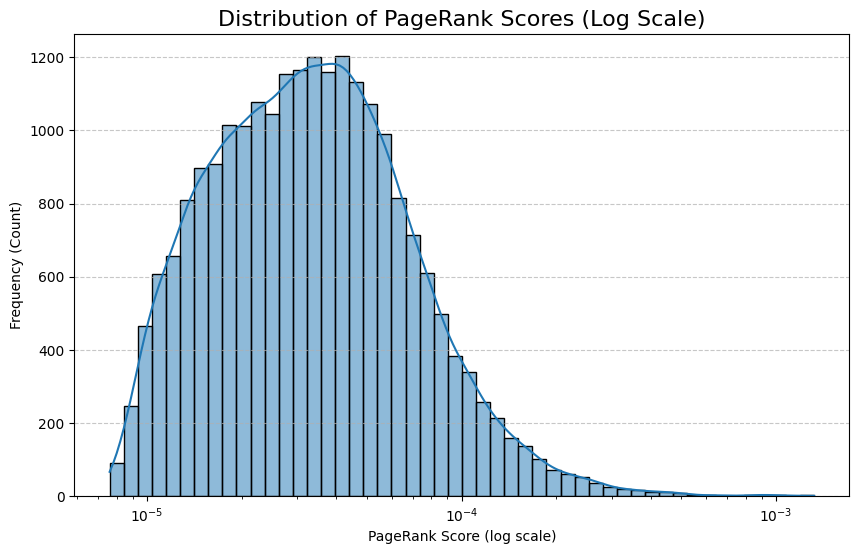

Most nodes have a very low PageRank score, with a long tail of high-scoring nodes.

Generating Plot 2: PageRank vs. Node Degree...


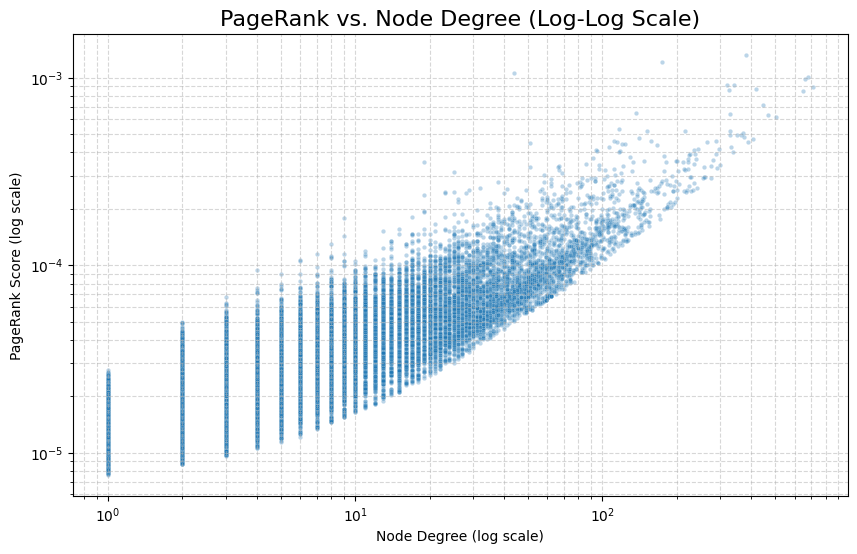

This plot visualizes the strong positive correlation (0.8587) we calculated earlier.

Generating Plot 3: Top 20 Nodes by PageRank...


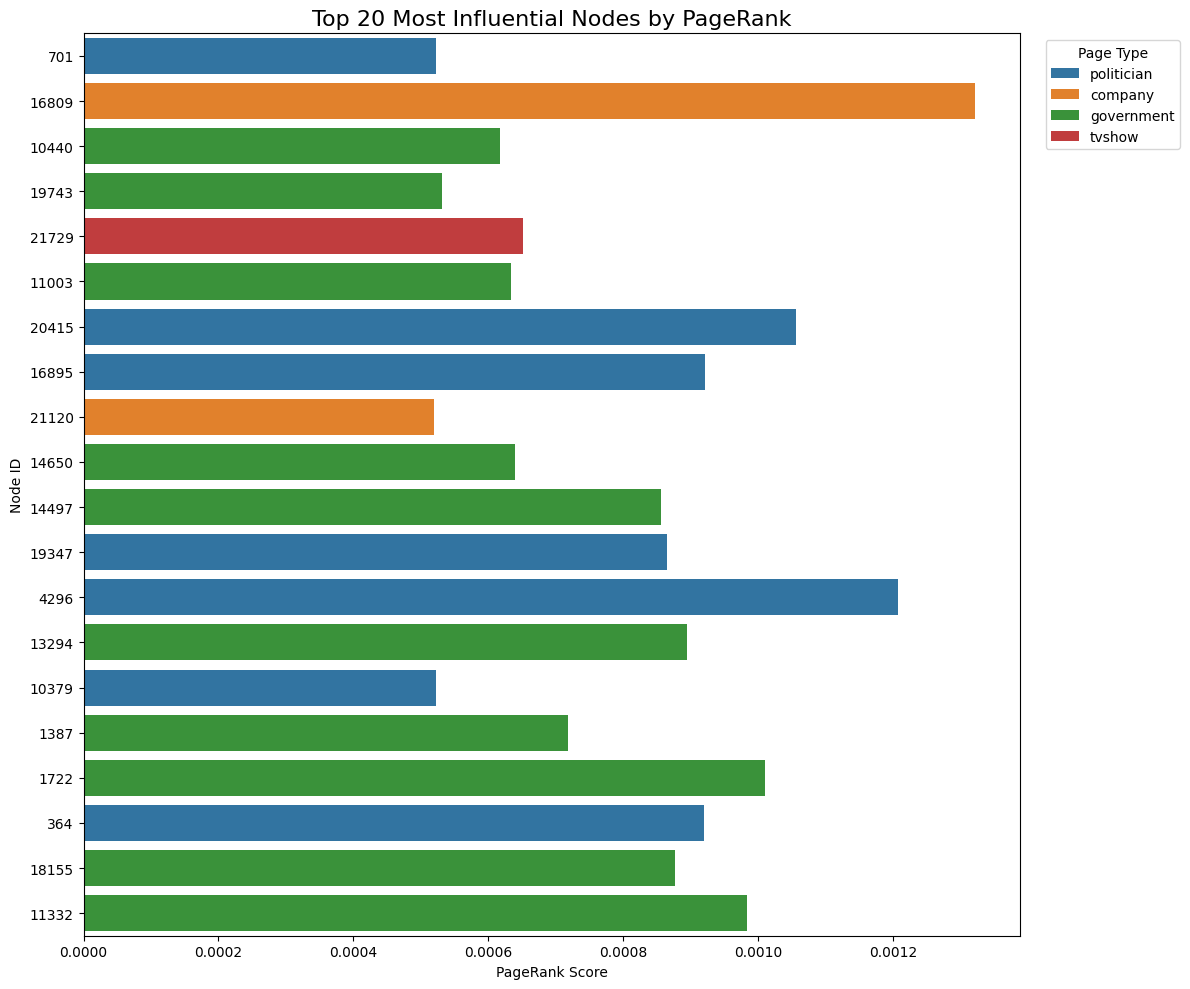

This plot shows which specific nodes are most central and what category they belong to.

Visualization complete.


In [11]:
# ---
# ---
# # Part 1.C: PageRank Visualization
# ---
# ---
print(f"\n{'='*20}\n PART 1.C: VISUALIZING PAGERANK\n{'='*20}")

# We need matplotlib and seaborn for plotting
try:
    import matplotlib.pyplot as plt
    import seaborn as sns
    print("Plotting libraries (matplotlib, seaborn) loaded.")
except ImportError:
    print("Please install matplotlib and seaborn: !pip install matplotlib seaborn")
    exit()

# ---
# 1. Create a DataFrame for visualization
# ---
# We'll combine the PageRank, Degree, and Page Type data
vis_df = pd.DataFrame({
    'id': node_ids_in_order,  # From the "Prepare Vector Data" section
    'PageRank': pr_list,      # From the "PageRank" section
    'Degree': deg_list        # From the "PageRank" section
})
# Merge with target data to get page types
vis_df = vis_df.merge(target_df[['id', 'page_type']], on='id', how='left')
print("Visualization DataFrame created with PageRank, Degree, and Page Type.")

# ---
# Plot 1: Distribution of PageRank Scores
# ---
print("\nGenerating Plot 1: Distribution of PageRank Scores...")
plt.figure(figsize=(10, 6))
# Using a log scale is essential as PageRank is often power-law distributed
sns.histplot(vis_df['PageRank'], bins=50, kde=True, log_scale=True)
plt.title('Distribution of PageRank Scores (Log Scale)', fontsize=16)
plt.xlabel('PageRank Score (log scale)')
plt.ylabel('Frequency (Count)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()
print("Most nodes have a very low PageRank score, with a long tail of high-scoring nodes.")

# ---
# Plot 2: PageRank vs. Degree (Scatter Plot)
# ---
print("\nGenerating Plot 2: PageRank vs. Node Degree...")
plt.figure(figsize=(10, 6))
# A scatter plot of all 22k nodes can be slow and hard to read.
# We can use a sample or set alpha transparency. Let's use alpha.
sns.scatterplot(data=vis_df, x='Degree', y='PageRank', alpha=0.3, s=10)
plt.xscale('log')
plt.yscale('log')
plt.title('PageRank vs. Node Degree (Log-Log Scale)', fontsize=16)
plt.xlabel('Node Degree (log scale)')
plt.ylabel('PageRank Score (log scale)')
plt.grid(True, which="both", ls="--", alpha=0.5)
plt.show()
print(f"This plot visualizes the strong positive correlation ({corr:.4f}) we calculated earlier.")

# ---
# Plot 3: Top 20 Nodes by PageRank
# ---
print("\nGenerating Plot 3: Top 20 Nodes by PageRank...")
top_20_pr = vis_df.nlargest(20, 'PageRank')

plt.figure(figsize=(12, 10))
sns.barplot(data=top_20_pr, x='PageRank', y='id', hue='page_type', orient='h', dodge=False)
# Convert y-axis labels to string to avoid numeric formatting issues
plt.yticks(ticks=range(len(top_20_pr)), labels=[str(i) for i in top_20_pr['id']])
plt.title('Top 20 Most Influential Nodes by PageRank', fontsize=16)
plt.xlabel('PageRank Score')
plt.ylabel('Node ID')
plt.legend(title='Page Type', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()
print("This plot shows which specific nodes are most central and what category they belong to.")

print("\nVisualization complete.")

Loading the Karate Club Graph...
Generating the graph visualization...
The plot shows the two factions of the club, colored in skyblue and orange.


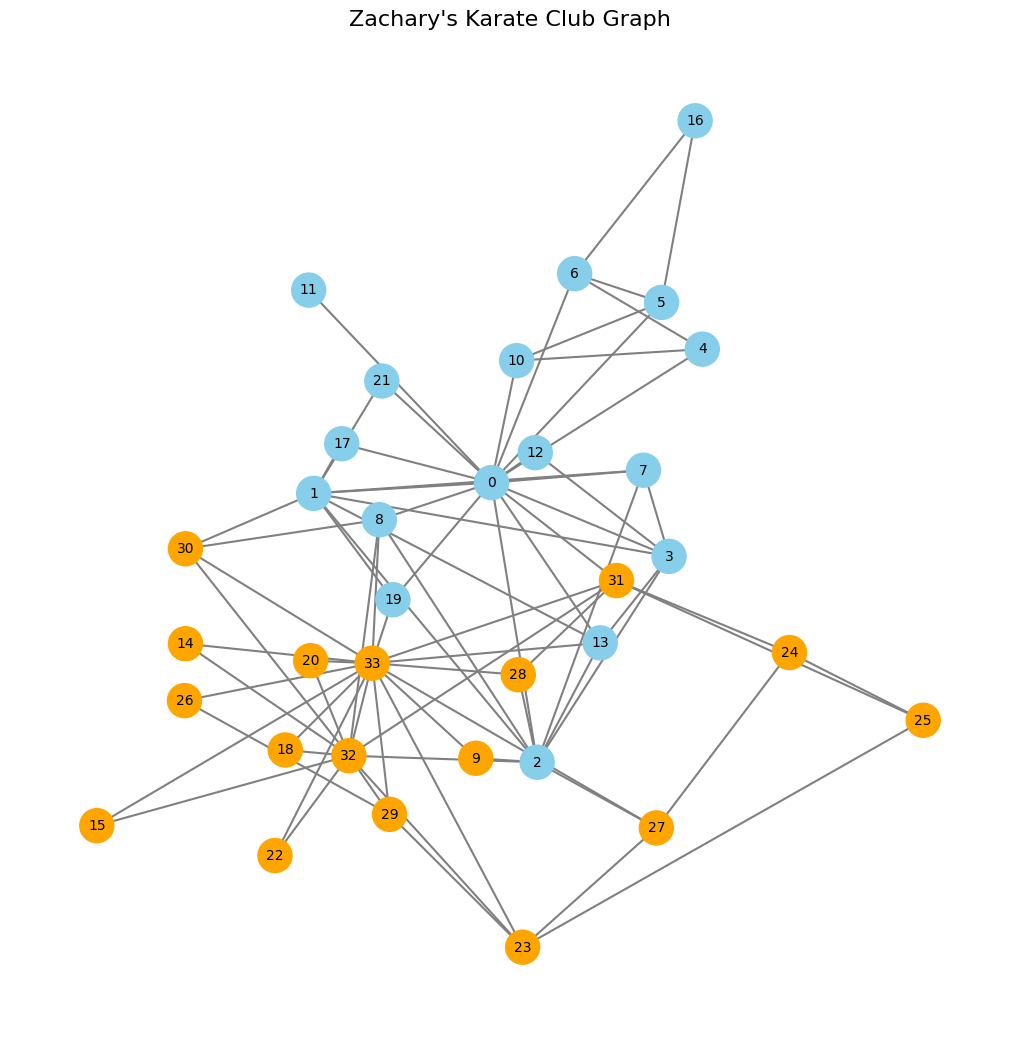


Calculating PageRank for Karate Club nodes...
Top 5 most influential nodes in the Karate Club:
  Node 33 (Club: Officer): PageRank = 0.0970
  Node 0 (Club: Mr. Hi): PageRank = 0.0885
  Node 32 (Club: Officer): PageRank = 0.0759
  Node 2 (Club: Mr. Hi): PageRank = 0.0628
  Node 1 (Club: Mr. Hi): PageRank = 0.0574


In [12]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

print("Loading the Karate Club Graph...")
# 1. Load the classic Karate Club graph
G = nx.karate_club_graph()

# ---
# 2. Prepare for Visualization
# ---
# The graph comes with a 'club' attribute for each node, which tells us
# which faction the member joined ('Mr. Hi' or 'Officer').
# We can use this to color the nodes.

# Create a list of colors based on the 'club' attribute
colors = []
for node in G.nodes():
    if G.nodes[node]['club'] == 'Mr. Hi':
        colors.append('skyblue')  # Color for Mr. Hi's faction
    else:
        colors.append('orange')   # Color for the Officer's faction

# ---
# 3. Draw the Graph
# ---
print("Generating the graph visualization...")
plt.figure(figsize=(10, 10))

# Use a layout that spreads out the nodes for better visibility
# Kamada-Kawai is often good for small, clustered graphs.
pos = nx.kamada_kawai_layout(G)

# Draw the network
nx.draw(G,
        pos,
        with_labels=True,      # Show node numbers
        node_color=colors,     # Use the faction colors
        node_size=600,         # Make nodes larger
        font_size=10,
        font_color='black',
        edge_color='gray',     # Make edges a neutral color
        width=1.5)             # Edge thickness

plt.title("Zachary's Karate Club Graph", fontsize=16)
print("The plot shows the two factions of the club, colored in skyblue and orange.")
plt.show()

# ---
# 4. Bonus: Calculate and Print PageRank
# ---
# Just like we did for the Facebook graph, we can find the most central nodes.
print("\nCalculating PageRank for Karate Club nodes...")
pagerank = nx.pagerank(G)
# Sort nodes by pagerank score in descending order
sorted_pagerank = sorted(pagerank.items(), key=lambda item: item[1], reverse=True)

print("Top 5 most influential nodes in the Karate Club:")
for node, score in sorted_pagerank[:5]:
    club = G.nodes[node]['club']
    print(f"  Node {node} (Club: {club}): PageRank = {score:.4f}")